In [1]:
import numpy as np
import os
os.chdir('/home/ia404/gitreps/dustbias/mbatch/local_dustbias/')
import argparse
import utils as autils
from utils import DUST_TYPES
from orphics import cosmology
import pyfisher
from sofind import DataModel
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D
from matplotlib import rcParams
from solenspipe.utility import w_n
rcParams['font.size']=20
rcParams['axes.linewidth']=1.5
rcParams['xtick.major.width']=1.5
rcParams['xtick.minor.width']=1
rcParams['ytick.major.width']=1.5
rcParams['ytick.minor.width']=1
rcParams['xtick.major.pad']='8'
rcParams['xtick.direction'] = 'in'
rcParams['xtick.top'] = True
rcParams['ytick.direction'] = 'in'
rcParams['xtick.minor.visible'] = True
rcParams['ytick.minor.visible'] = True
rcParams['ytick.right'] = True
rcParams['text.usetex'] = True
rcParams['font.family'] = 'Helvetica'

%matplotlib inline

--------------------------------------------------------------------------
but there are no active ports detected (or Open MPI was unable to use
them).  This is most certainly not what you wanted.  Check your
cables, subnet manager configuration, etc.  The openib BTL will be
ignored for this job.

  Local host: cpu-q-183
--------------------------------------------------------------------------


In [2]:
dict_plot = {}
#dict_plot['GAL040'] = {'linestyle': 'dotted', 'label': 'ACT 40\%'}
dict_plot['GAL060'] = {'linestyle': 'dashed', 'label': 'ACT 60\%'}
dict_plot['GAL070'] = {'linestyle': 'solid', 'label': 'ACT 70\%'}
dict_plot['GAL080'] = {'linestyle': 'dotted', 'label': 'ACT 80\%'}

# dict_plot['lmin100'] = {'linestyle': 'dotted', 'label': r'$\ell_{\textrm{min}} = 100$'}
# dict_plot['lmin1000'] = {'linestyle': 'dashed', 'label': r'$\ell_{\textrm{min}} = 1000$'}
# dict_plot['lmin600'] = {'linestyle': 'solid', 'label': r'$\ell_{\textrm{min}} = 600$'}
# dict_plot['lmax3000'] = {'linestyle': 'solid', 'label': r'$\ell_{\textrm{max}} = 3000$'}
# dict_plot['lmax3500'] = {'linestyle': 'dashed', 'label': r'$\ell_{\textrm{max}} = 3500$'}

cmap = plt.cm.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, 6)]

dict_plot['gauss'] = {'color': colors[0], 'label': 'Gaussian field'}
dict_plot['d9'] = {'color': colors[1], 'label': 'PySM d9'}
dict_plot['d10'] = {'color': colors[2], 'label': 'PySM d10'}
dict_plot['d12'] = {'color': colors[3], 'label': 'PySM d12'}
dict_plot['DF'] = {'color': colors[4], 'label': 'DUSTFILAMENTS'}
dict_plot['van'] = {'color': colors[5], 'label': 'Vansyngel+17'}

In [3]:
args = argparse.Namespace()

args.mlmax=4000

args.width_ra=15
args.width_dec=10

# args.lmax=3000
# args.lmin=600
args.filter_whiteamplitude=12.
args.filter_whitefwhm=1.4

args.nsims_mf=50

args.config_name='act_dr6v4'
args.apodfact = '_d2apo3deg'
args.daynight='night'
args.mask_type='dr6v4_20240919'
args.mask_subproduct = 'lensing_masks'

args.est= 'TT'
args.output_dir = '/rds/project/dirac_vol5/rds-dirac-dp002/ia404/fgs/local_dustbias/'

In [4]:
dm = DataModel.from_config(args.config_name)
mask_options = {'apodfact': args.apodfact, 'daynight': args.daynight}

masks = []
wmasks_dict = {}
for skyfrac in ['GAL060', 'GAL070', 'GAL080']:
    mask_options['skyfrac'] = (skyfrac).split('GAL0')[1]
    mask = dm.read_mask(subproduct=args.mask_subproduct, mask_type=args.mask_type,**mask_options)
    masks.append(mask)
    wmasks_dict[skyfrac] = w_n(mask,1)

In [5]:
ell_arr = np.arange(args.mlmax+1)
lfac = (ell_arr * (ell_arr + 1))**2 / (2 * np.pi)
lfac_2pt = ell_arr * (ell_arr + 1)
lcut = 50
nbands_log = 20
nbands_lin = 5
lbands = np.concatenate((np.linspace(2, lcut, nbands_lin, dtype=int)[:-1], np.logspace(np.log10(lcut), np.log10(args.mlmax), nbands_log+1, dtype=int)))#  dtype=int)
nbands = len(lbands)-1
# leff = (lbands[1:] + lbands[:-1])/2. # [np.mean(np.arange(x,y)) for x,y in zip(lbands[:-1], lbands[1:])]

In [6]:
# cents, bins = pyfisher.get_binner(lbands,interpolate=False)

In [7]:
theory = cosmology.default_theory()
tclkk = theory.gCl('kk',ell_arr)

tclpp = tclkk * 4 / (ell_arr * (ell_arr+1))**2
# tclkk_bin = bins(pyfisher.interp(ell_arr, tclkk, bounds_error=True))

/tmp/ipykernel_2186369/3636017728.py:4: RuntimeWarning: invalid value encountered in divide
  tclpp = tclkk * 4 / (ell_arr * (ell_arr+1))**2


In [8]:
# args.lmin = 600
# args.lmax = 3000
# autils.get_norm_name(args)

In [9]:
# # load filters
# Als = np.load(baseline_path + f'stage_compute_filters/{autils.get_norm_name(args)}', allow_pickle=True).item()

In [10]:
# Nl = Als[args.est][0] * (ell_arr*(ell_arr+1.)/2.)**2.
# nls_kk_bin = bins(pyfisher.interp(ells,Nl,bounds_error=True))

In [11]:
# delta_ell = np.diff(lbands)
# covariance_factor = 1/(delta_ell*fsky*(2*cents+1))
# covariance = 2 * (tclkk_bin + nls_kk_bin)**2 * covariance_factor

In [12]:
def return_sigmaAlens(args, lmin, lmax, lbands, fsky):
    # lbands is bin_edges
    
    ell_arr = np.arange(args.mlmax+1)
    cents, bins = pyfisher.get_binner(lbands,interpolate=False)
    
    args.lmin = lmin
    args.lmax = lmax
    
    theory = cosmology.default_theory()
    tclkk = theory.gCl('kk',ell_arr)
    tclkk_bin = bins(pyfisher.interp(ell_arr, tclkk, bounds_error=True))
    
    Als = np.load(args.output_dir + f'stage_compute_filters/{autils.get_norm_name(args)}', allow_pickle=True).item()
    
    Nl = Als[args.est][0] * (ell_arr*(ell_arr+1.)/2.)**2.
    nls_kk_bin = bins(pyfisher.interp(ell_arr,Nl,bounds_error=True))
    
    delta_ell = np.diff(lbands)
    covariance_factor = 1/(delta_ell*fsky*(2*cents+1))
    covariance = 2 * (tclkk_bin + nls_kk_bin)**2 * covariance_factor
    
    return covariance, tclkk_bin # , sum(tclkk_bin**2/covariance), 1/np.sqrt(sum(tclkk_bin**2 / covariance))

In [13]:
# computation = return_sigmaAlens(args, 600, 3000, lbands, 0.3)
# computation

In [14]:
npatches = {}
for skyfrac in autils.FSKYS:
    npatches[skyfrac] = np.load(args.output_dir + f'local_masks/submap_coordinates_{skyfrac}_{args.width_ra}_{args.width_dec}.npy').shape[0]
print(npatches)

{'GAL060': 111, 'GAL070': 118, 'GAL080': 133}


In [15]:
def args_baseline(args, skyfrac, dust_type):
    
    args.lmax=3000
    args.lmin=600
    args.dust_type=dust_type
    args.dust_freq=150.
    args.skyfrac=skyfrac
    
    return args

# def args_lmin(args, lmin, dust_type, skyfrac='GAL070'):
    
#     args.lmax=3000
#     args.lmin=lmin
#     args.dust_type=dust_type
#     args.dust_freq=150.
#     args.skyfrac=skyfrac
    
#     return args

# def args_lmax(args, lmax, dust_type, skyfrac='GAL070'):
    
#     args.lmax=lmax
#     args.lmin=600
#     args.dust_type=dust_type
#     args.dust_freq=150.
#     args.skyfrac=skyfrac
    
#     return args

In [16]:
path_recons = lambda ipatch, args, tag, mf: args.output_dir + f'stage_reconstruction/{autils.get_recons_name(ipatch, args, tag, mf)}'

In [17]:
raw_4pt = {}
rawmf_4pt = {}
n0_4pt = {}
reconstructed_cl = {}
cl_nobias = {}

for skyfrac in autils.FSKYS:
    for dust_type in autils.DUST_TYPES:
        for test in ['baseline', 'lmin1000', 'lmin100', 'lmax3500']:
            
            raw_4pt[f'{dust_type}_{skyfrac}_{test}'] = [None] * npatches[skyfrac]
            rawmf_4pt[f'{dust_type}_{skyfrac}_{test}'] = [None] * npatches[skyfrac]
            n0_4pt[f'{dust_type}_{skyfrac}_{test}'] = [None] * npatches[skyfrac]
            cl_nobias[f'{dust_type}_{skyfrac}_{test}'] = [None] * npatches[skyfrac]

In [24]:
TEST='baseline'

for SKYFRAC in autils.FSKYS:
    for n in range(npatches[SKYFRAC]):
        for dust_type in autils.DUST_TYPES:
            raw_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = np.loadtxt(path_recons(n, args_baseline(args, SKYFRAC, dust_type), 'auto', mf=False))
            rawmf_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = np.loadtxt(path_recons(n, args_baseline(args, SKYFRAC, dust_type), 'auto', mf=True))
            n0_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = np.loadtxt(path_recons(n, args_baseline(args, SKYFRAC, dust_type), 'N0', mf=False))

for SKYFRAC in autils.FSKYS:
    for n in range(npatches[SKYFRAC]):
        for dust_type in autils.DUST_TYPES:
            cl_nobias[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = rawmf_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n][:args.mlmax+1] - n0_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n][:args.mlmax+1]

for SKYFRAC in autils.FSKYS:
    for dust_type in autils.DUST_TYPES:
        reconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}'] = np.nanmean(np.asarray(list(cl_nobias[f'{dust_type}_{SKYFRAC}_{TEST}'])), axis=0)

/tmp/ipykernel_2186369/4174546873.py:17: RuntimeWarning: Mean of empty slice
  reconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}'] = np.nanmean(np.asarray(list(cl_nobias[f'{dust_type}_{SKYFRAC}_{TEST}'])), axis=0)


In [19]:
# SKYFRAC='GAL070'

# for TEST in ['lmin100', 'lmin1000']:
#     lmin = TEST.split('lmin')[1]
#     for n in range(npatches[SKYFRAC]):
#         for dust_type in autils.DUST_TYPES:
#             raw_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = np.loadtxt(path_recons(n, args_lmin(args, lmin, dust_type), 'auto', mf=False))
#             rawmf_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = np.loadtxt(path_recons(n, args_lmin(args, lmin, dust_type), 'auto', mf=True))
#             n0_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = np.loadtxt(path_recons(n, args_lmin(args, lmin, dust_type), 'N0', mf=False))

# for TEST in ['lmin100', 'lmin1000']:
#     for n in range(npatches[SKYFRAC]):
#         for dust_type in autils.DUST_TYPES:
#             cl_nobias[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = rawmf_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n][:args.mlmax+1] - n0_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n][:args.mlmax+1]

# for TEST in ['lmin100', 'lmin1000']:
#     for dust_type in autils.DUST_TYPES:
#         reconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}'] = np.nanmean(np.asarray(list(cl_nobias[f'{dust_type}_{SKYFRAC}_{TEST}'])), axis=0)

In [20]:
# SKYFRAC = 'GAL070'
# TEST='lmax3500'
# lmax=TEST.split('lmax')[1]

# for n in range(npatches[SKYFRAC]):
#     for dust_type in autils.DUST_TYPES:
#         raw_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = np.loadtxt(path_recons(n, args_lmax(args, lmax, dust_type), 'auto', mf=False))
#         rawmf_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = np.loadtxt(path_recons(n, args_lmax(args, lmax, dust_type), 'auto', mf=True))
#         n0_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = np.loadtxt(path_recons(n, args_lmax(args, lmax, dust_type), 'N0', mf=False))

# for n in range(npatches[SKYFRAC]):
#     for dust_type in autils.DUST_TYPES:
#         cl_nobias[f'{dust_type}_{SKYFRAC}_{TEST}'][n] = rawmf_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n][:args.mlmax+1] - n0_4pt[f'{dust_type}_{SKYFRAC}_{TEST}'][n][:args.mlmax+1]

# for dust_type in autils.DUST_TYPES:
#     reconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}'] = np.nanmean(np.asarray(list(cl_nobias[f'{dust_type}_{SKYFRAC}_{TEST}'])), axis=0)

In [21]:
cents, bins = pyfisher.get_binner(lbands,interpolate=False)

/tmp/ipykernel_3255730/2265070822.py:9: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(-1e-12, 5e-7) # #pyfisher.interp(ell_arr, tclkk, bounds_error=True))
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


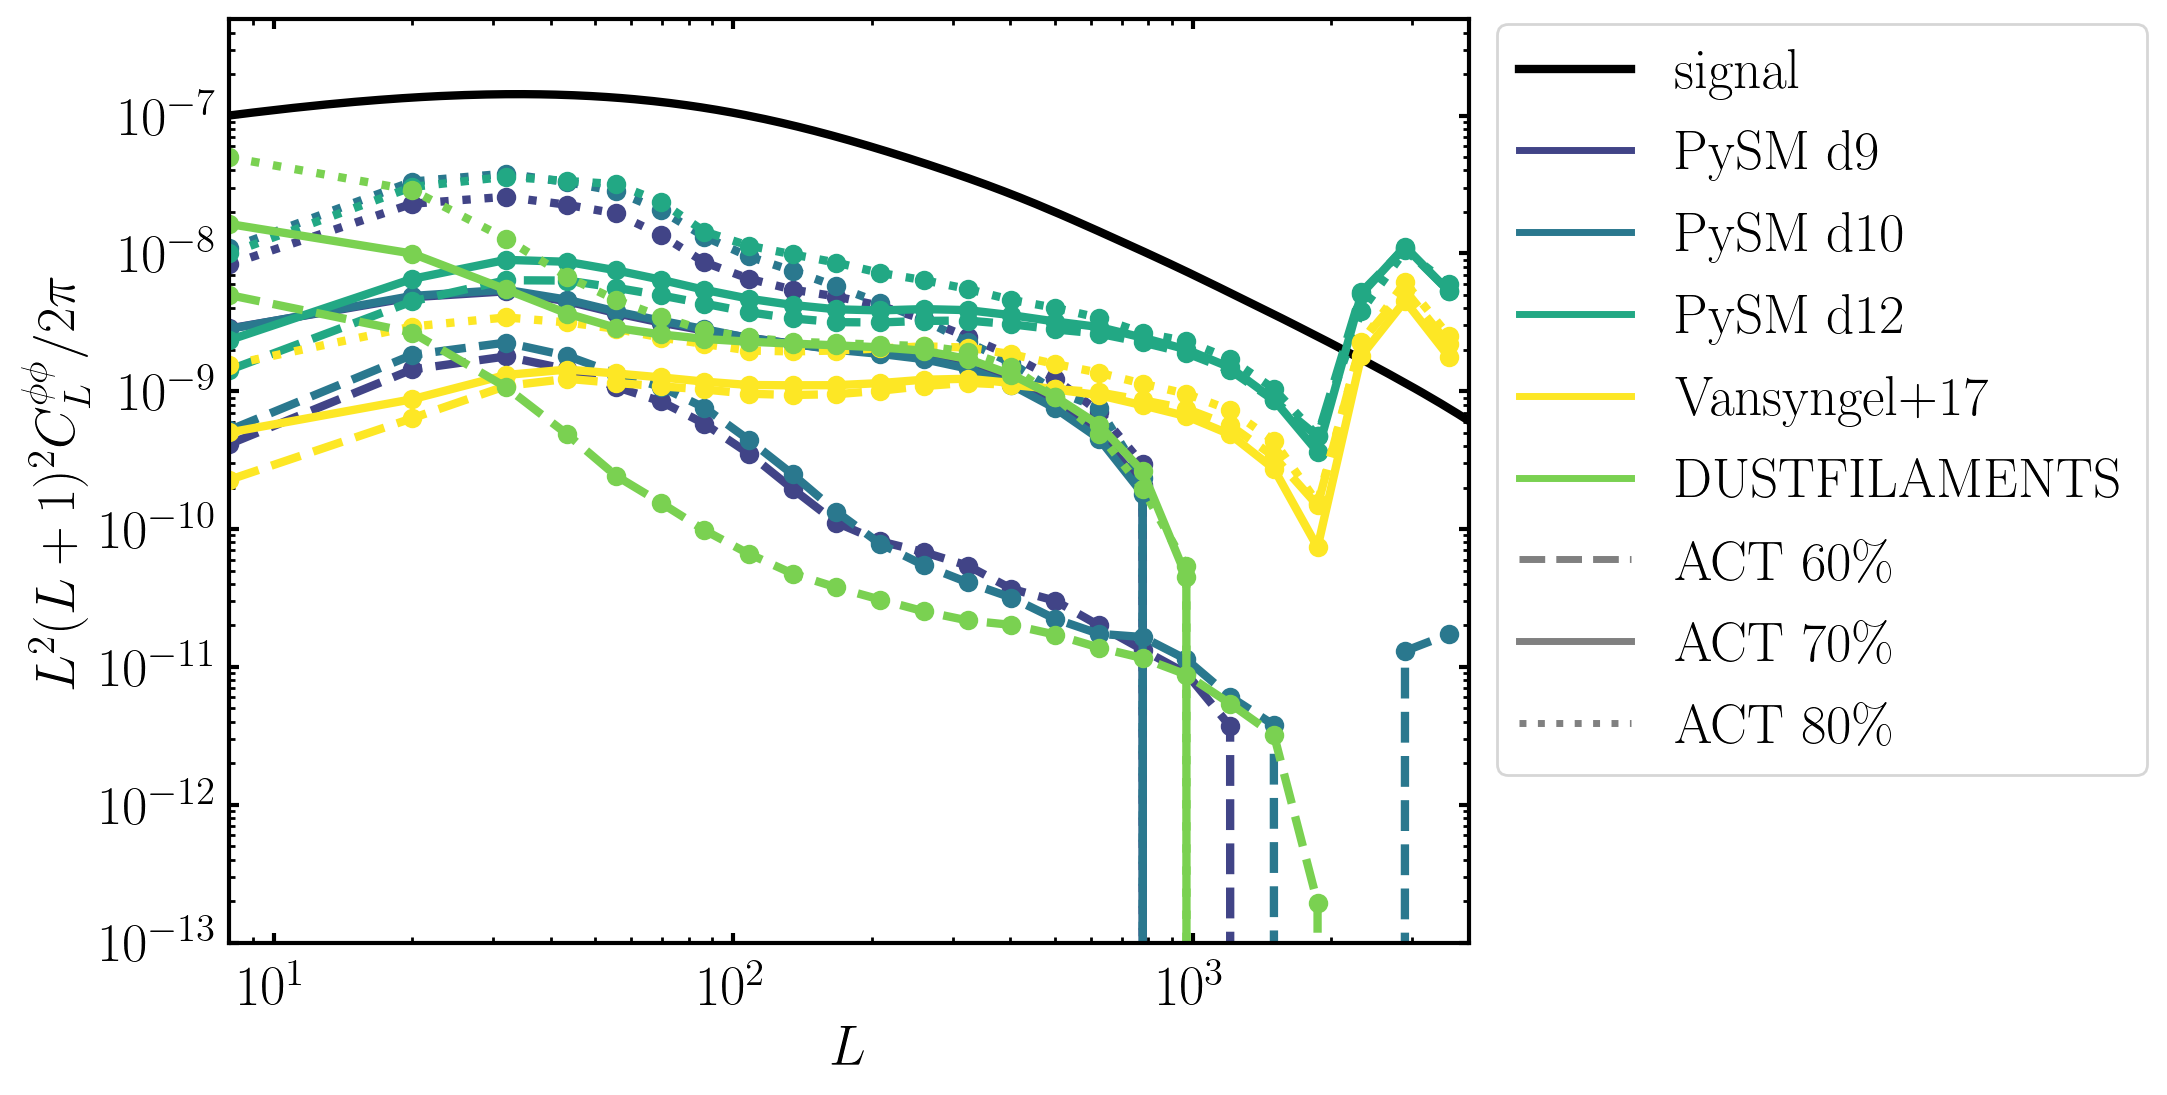

In [17]:
TEST='baseline'

fig, ax = plt.subplots(1, 1, figsize=(8,6), dpi=200)

ax.loglog(ell_arr[2:], (tclpp*lfac)[2:], linestyle = 'solid', color ='k', linewidth = 3, label='signal')
for dust_type in autils.DUST_TYPES[1:]:
    for SKYFRAC in autils.FSKYS:
        ax.loglog(cents, (bins(pyfisher.interp(ell_arr, lfac*reconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}'], bounds_error=True))),'o-',color=dict_plot[dust_type]['color'], linestyle=dict_plot[SKYFRAC]['linestyle'], linewidth = 3, label=dust_type)#)))#[:args.mlmax+1]*lfac)[2:] / (clpp[:args.mlmax+1]*lfac)[2:], color=dict_plot[dust_type]['color'], linestyle=dict_plot[SKYFRAC]['linestyle'], linewidth = 3, label=dust_type)
ax.set_ylim(-1e-12, 5e-7) # #pyfisher.interp(ell_arr, tclkk, bounds_error=True))
ax.set_xlim(8,4000)

custom_lines1 = [Line2D([0], [0], color='black', linestyle = 'solid', lw=3)]
custom_lines2 = [Line2D([0], [0], color=dict_plot[fg_type]['color'], linestyle = 'solid', lw=2.5) for fg_type in autils.DUST_TYPES[1:]]
custom_lines3 = [Line2D([0], [0], color='gray', linestyle = dict_plot[GAL]['linestyle'], lw=2.5) for GAL in autils.FSKYS]

custom_lines = custom_lines1 + custom_lines2 + custom_lines3

legend_lines1 = ['signal']
legend_lines2 = [dict_plot[fg_type]['label'] for fg_type in autils.DUST_TYPES[1:]]
legend_lines3 = [dict_plot[GAL]['label'] for GAL in autils.FSKYS]

legend_lines = legend_lines1 + legend_lines2 +legend_lines3 

legend = ax.legend(custom_lines, legend_lines, bbox_to_anchor=(1, 1.025), loc = 'upper left')

ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$L^2(L+1)^2C_L^{\phi\phi}/2\pi$')

fig.savefig('/home/ia404/gitreps/dustbias/mbatch/local_dustbias/Figures/baseline_fsky_150.png', bbox_inches='tight')

/tmp/ipykernel_3255730/3108898826.py:8: RuntimeWarning: divide by zero encountered in divide
  ax.loglog(cents, (bins(pyfisher.interp(ell_arr, (reconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}']/tclpp), bounds_error=True))),'o-',color=dict_plot[dust_type]['color'], linestyle=dict_plot[SKYFRAC]['linestyle'], linewidth = 3, label=dust_type)
/tmp/ipykernel_3255730/3108898826.py:8: RuntimeWarning: divide by zero encountered in divide
  ax.loglog(cents, (bins(pyfisher.interp(ell_arr, (reconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}']/tclpp), bounds_error=True))),'o-',color=dict_plot[dust_type]['color'], linestyle=dict_plot[SKYFRAC]['linestyle'], linewidth = 3, label=dust_type)
/tmp/ipykernel_3255730/3108898826.py:8: RuntimeWarning: divide by zero encountered in divide
  ax.loglog(cents, (bins(pyfisher.interp(ell_arr, (reconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}']/tclpp), bounds_error=True))),'o-',color=dict_plot[dust_type]['color'], linestyle=dict_plot[SKYFRAC]['linestyle'], linewidth = 

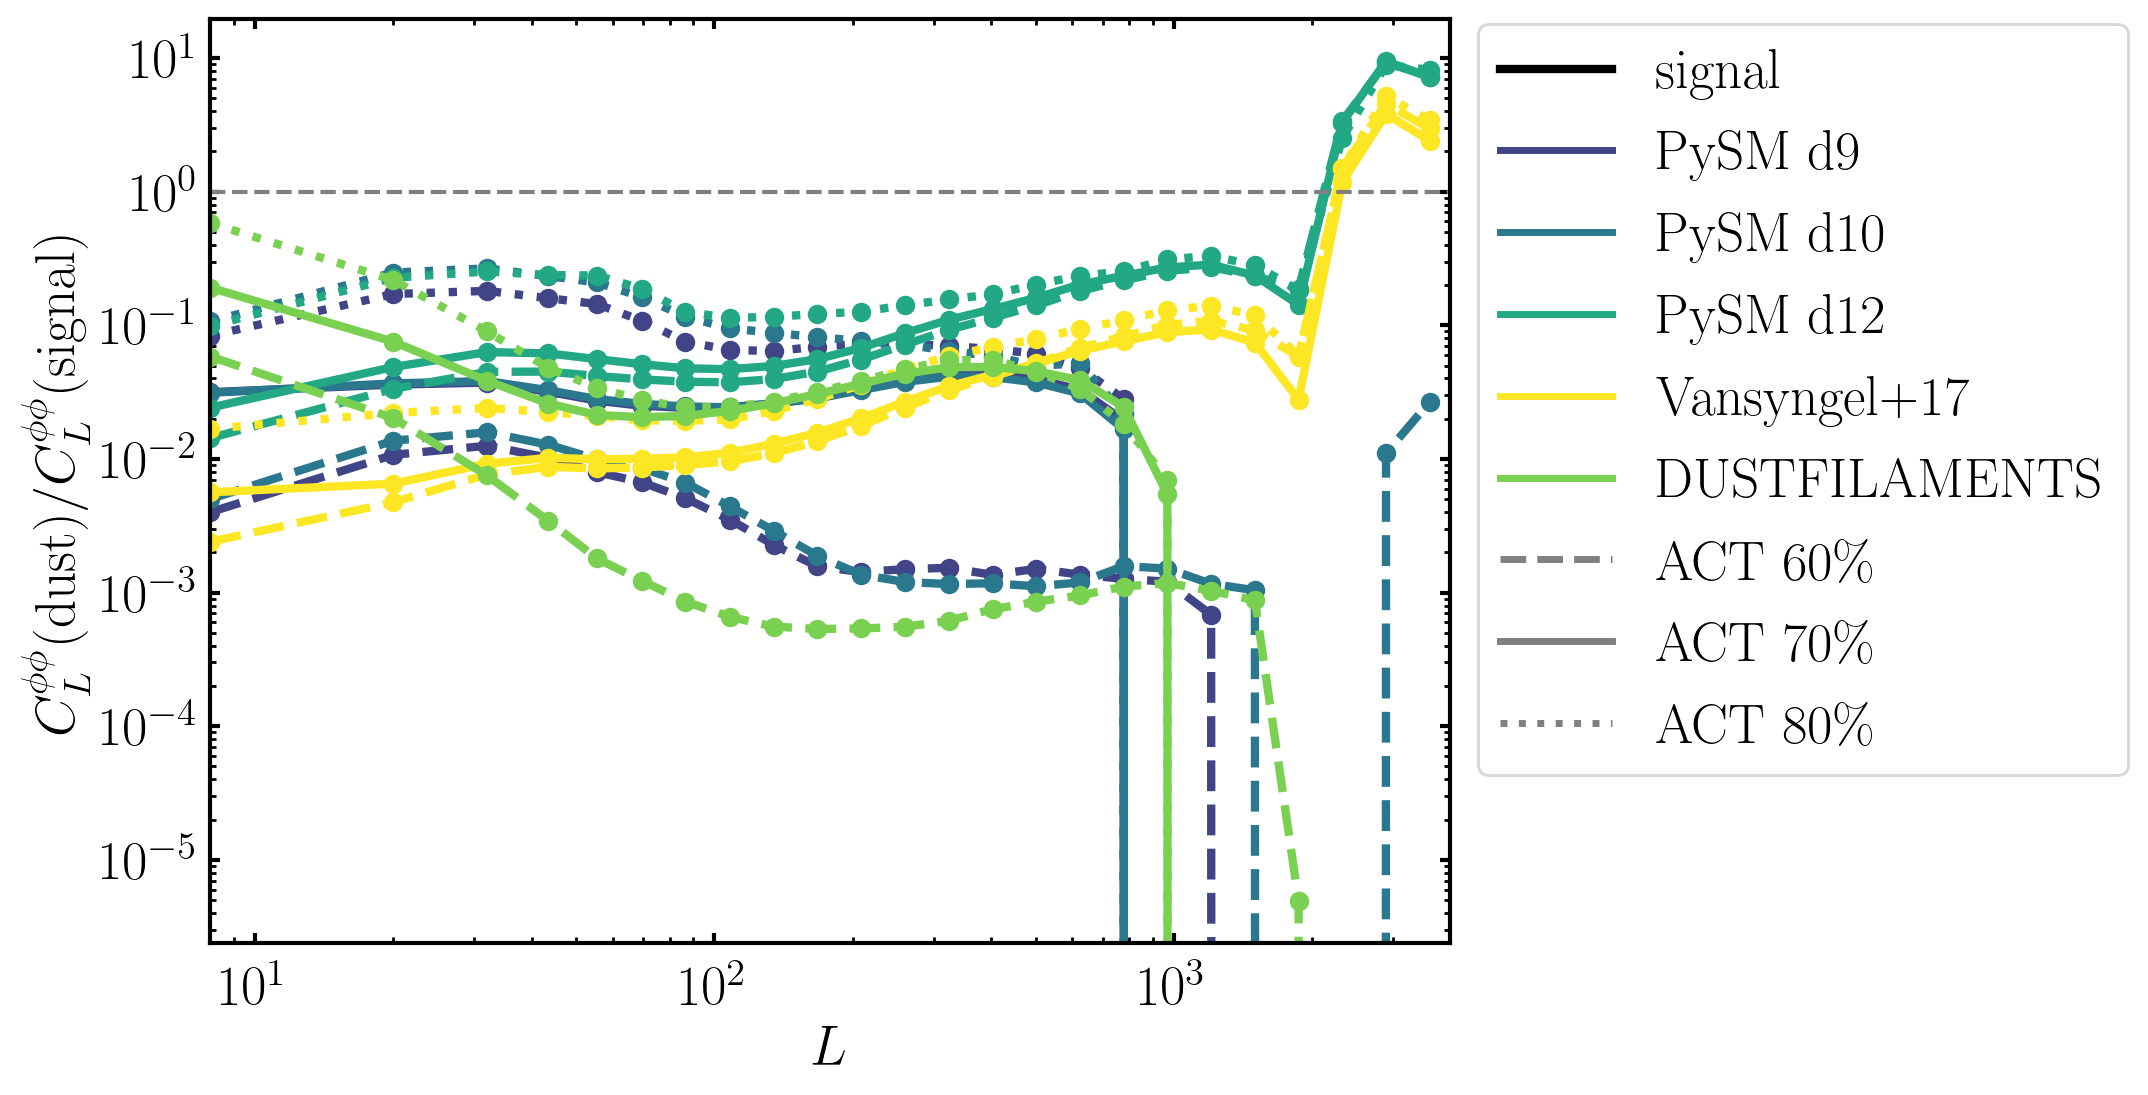

In [18]:
TEST='baseline'
SKYFRAC = 'GAL060'

fig, ax = plt.subplots(1, 1, figsize=(8,6), dpi=200)

for dust_type in autils.DUST_TYPES[1:]:
    for SKYFRAC in autils.FSKYS:
        ax.loglog(cents, (bins(pyfisher.interp(ell_arr, (reconstructed_cl[f'{dust_type}_{SKYFRAC}_{TEST}']/tclpp), bounds_error=True))),'o-',color=dict_plot[dust_type]['color'], linestyle=dict_plot[SKYFRAC]['linestyle'], linewidth = 3, label=dust_type)

ax.set_xlim(8,4000)

ax.axhline(1, color='gray', linestyle='dashed')

custom_lines1 = [Line2D([0], [0], color='black', linestyle = 'solid', lw=3)]
custom_lines2 = [Line2D([0], [0], color=dict_plot[fg_type]['color'], linestyle = 'solid', lw=2.5) for fg_type in autils.DUST_TYPES[1:]]
custom_lines3 = [Line2D([0], [0], color='gray', linestyle = dict_plot[GAL]['linestyle'], lw=2.5) for GAL in autils.FSKYS]

custom_lines = custom_lines1 + custom_lines2 + custom_lines3

legend_lines1 = ['signal']
legend_lines2 = [dict_plot[fg_type]['label'] for fg_type in autils.DUST_TYPES[1:]]
legend_lines3 = [dict_plot[GAL]['label'] for GAL in autils.FSKYS]

legend_lines = legend_lines1 + legend_lines2 +legend_lines3 

legend = ax.legend(custom_lines, legend_lines, bbox_to_anchor=(1, 1.025), loc = 'upper left')

ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$C_L^{\phi\phi}\textrm{(dust)}/C_L^{\phi\phi}\textrm{(signal)}$')
fig.savefig('/home/ia404/gitreps/dustbias/mbatch/local_dustbias/Figures/baseline_fsky_ratio_150.png', bbox_inches='tight')
plt.show()

In [22]:
# covariance = return_sigmaAlens(args, 600, 3000, lbands, 0.3)[0]
# cov2 = return_sigmaAlens(args, 600,3500, lbands, 0.3)[0]
# cov3 = return_sigmaAlens(args, 100,3000, lbands, 0.3)[0]

In [22]:
def calculate_Alens(reconstructed_cl, lmin, lmax, lbands, args, fsky, Lmin, Lmax, pp=True):
    
    ell_arr = np.arange(args.mlmax+1)
    cents, bins = pyfisher.get_binner(lbands,interpolate=False)

    if pp:
        bandpowers = reconstructed_cl * (ell_arr*(ell_arr+1.)/2.)**2.
    else:
        bandpowers = reconstructed_cl
    bandpowers = (bins(pyfisher.interp(ell_arr, bandpowers, bounds_error=True)))
    
    covariance, tclkk_bin = return_sigmaAlens(args, lmin, lmax, lbands, fsky)
    # , sum(tclkk_bin**2/covariance), 1/np.sqrt(sum(tclkk_bin**2 / covariance))
    
    Lrange = (cents > Lmin) & (cents < Lmax)
    
    sAlens = 1/np.sqrt(sum(tclkk_bin[Lrange]**2/ covariance[Lrange]))
    DAlens = sum(bandpowers[Lrange] * tclkk_bin[Lrange] / covariance[Lrange]) / sum(tclkk_bin[Lrange]**2/ covariance[Lrange])
    
    return sAlens, DAlens*100, DAlens/sAlens

In [32]:
lmin = 600
lmax = 3000
print(f'(600, 3000) GAL070 sigma(Alens) = {calculate_Alens(reconstructed_cl[f"gauss_GAL060_baseline"],lmin, lmax, lbands, args, wmasks_dict["GAL070"], 10, 3000)[0]:.4f}')

lmin=100
lmax=3000
print(f'(100, 3000) GAL070 sigma(Alens) = {calculate_Alens(reconstructed_cl[f"gauss_GAL060_baseline"],lmin, lmax, lbands, args, wmasks_dict["GAL070"], 10, 3000)[0]:.4f}')

lmin=1000
lmax=3000
print(f'(1000, 3000) GAL070 sigma(Alens) = {calculate_Alens(reconstructed_cl[f"gauss_GAL060_baseline"],lmin, lmax, lbands, args, wmasks_dict["GAL070"], 10, 3000)[0]:.4f}')

lmin=600
lmax=3500
print(f'(600, 3500) GAL070 sigma(Alens) = {calculate_Alens(reconstructed_cl[f"gauss_GAL060_baseline"],lmin, lmax, lbands, args, wmasks_dict["GAL070"], 10, 3000)[0]:.4f}')

lmin = 600
lmax = 3000
print(f'(600, 3000) GAL060 sigma(Alens) = {calculate_Alens(reconstructed_cl[f"gauss_GAL060_baseline"],lmin, lmax, lbands, args, wmasks_dict["GAL060"], 10, 3000)[0]:.4f}')

lmin = 600
lmax = 3000
print(f'(600, 3000) GAL080 sigma(Alens) = {calculate_Alens(reconstructed_cl[f"gauss_GAL060_baseline"],lmin, lmax, lbands, args, wmasks_dict["GAL080"], 10, 3000)[0]:.4f}')


(600, 3000) GAL070 sigma(Alens) = 0.0113
(100, 3000) GAL070 sigma(Alens) = 0.0111
(1000, 3000) GAL070 sigma(Alens) = 0.0118
(600, 3500) GAL070 sigma(Alens) = 0.0096
(600, 3000) GAL060 sigma(Alens) = 0.0118
(600, 3000) GAL080 sigma(Alens) = 0.0107


In [25]:
test='baseline'

Lmin=10
Lmax=3000 # 000

print(f'Lmin = {Lmin}')
print(f'Lmax = {Lmax}\n')

print(r'$\Delta(A_{lens}) \times 100$', '\n')

for dust_type in autils.DUST_TYPES[1:]:
    for SKYFRAC in autils.FSKYS:
        
        print(dust_type, SKYFRAC, f"{(calculate_Alens(reconstructed_cl[f'{dust_type}_{SKYFRAC}_baseline'], args.lmin, args.lmax, lbands, args, wmasks_dict[SKYFRAC], Lmin, Lmax))[1]:.3f}")

Lmin = 10
Lmax = 3000

$\Delta(A_{lens}) \times 100$ 

d9 GAL060 0.202
d9 GAL070 2.466
d9 GAL080 4.809
d10 GAL060 0.229
d10 GAL070 2.296
d10 GAL080 5.558
d12 GAL060 11.665
d12 GAL070 13.134
d12 GAL080 18.624
van GAL060 4.244
van GAL070 4.096
van GAL080 6.429
DF GAL060 0.095
DF GAL070 2.791
DF GAL080 3.246


In [23]:
test='baseline'

Lmin=40
Lmax=763 # 000

print(f'Lmin = {Lmin}')
print(f'Lmax = {Lmax}\n')

print(r'$\Delta(A_{lens}) \times 100$', '\n')

for dust_type in autils.DUST_TYPES[1:]:
    for SKYFRAC in autils.FSKYS:
        
        print(dust_type, SKYFRAC, f"{(calculate_Alens(reconstructed_cl[f'{dust_type}_{SKYFRAC}_baseline'], args.lmin, args.lmax, lbands, args, wmasks_dict[SKYFRAC], Lmin, Lmax))[1]:.3f}")

Lmin = 40
Lmax = 763

$\Delta(A_{lens}) \times 100$ 

d9 GAL060 0.216
d9 GAL070 3.495
d9 GAL080 7.027
d10 GAL060 0.230
d10 GAL070 3.379
d10 GAL080 7.771
d12 GAL060 8.634
d12 GAL070 10.166
d12 GAL080 15.963
van GAL060 2.979
van GAL070 3.101
van GAL080 5.047
DF GAL060 0.075
DF GAL070 3.804
DF GAL080 4.074


In [ ]:
0.00

In [39]:
test='baseline'

Lmin=10
Lmax=4000

print(f'Lmin = {Lmin}')
print(f'Lmax = {Lmax}\n')

print(r'$\Delta(A_{lens}) + DeltaAlens/sigma$', '\n')

for dust_type in autils.DUST_TYPES[1:]:
    for SKYFRAC in autils.FSKYS:
        
        b1 = calculate_Alens(reconstructed_cl[f'{dust_type}_{SKYFRAC}_baseline'], args.lmin, args.lmax, lbands, args, wmasks_dict[SKYFRAC], Lmin, Lmax)
        
        print(dust_type, SKYFRAC, f"{(b1)[1]/100:.3f}",f"{(b1)[2]:.3f}" )

Lmin = 10
Lmax = 4000

$\Delta(A_{lens}) + DeltaAlens/sigma$ 

d9 GAL060 0.002 0.171
d9 GAL070 0.024 2.148
d9 GAL080 0.047 4.359
d10 GAL060 0.002 0.194
d10 GAL070 0.022 1.993
d10 GAL080 0.054 5.056
d12 GAL060 0.118 10.025
d12 GAL070 0.133 11.824
d12 GAL080 0.188 17.511
van GAL060 0.043 3.654
van GAL070 0.042 3.691
van GAL080 0.065 6.059
DF GAL060 0.001 0.081
DF GAL070 0.027 2.438
DF GAL080 0.032 2.972


In [154]:
from scipy.constants import physical_constants

In [155]:
h_JHz = physical_constants['Planck constant'][0]
k_JK  = physical_constants['Boltzmann constant'][0]
T_CMB =  2.72548

In [156]:
def fcmb(nu):

    '''
    spectral energy density in CMB units

    ** parameters **
    nu: float
        frequency in GHz
    '''

    x = h_JHz * 1e9/(k_JK*T_CMB) *nu
    return np.exp(x)*(x/(np.expm1(x)))**2

#All spectra
def comp_sed(nu,nu0,beta,temp,typ):

    '''
    SED for CMB and dust components
    '''

    if typ == 'cmb':
        return fcmb(nu)
    if typ == 'dust':
        x_to=0.04799244662211351*nu/temp
        x_from=0.04799244662211351*nu0/temp
        return (nu/nu0)**(1+beta)*np.expm1(x_from)/np.expm1(x_to)*fcmb(nu0)
    elif typ == 'sync':
        return (nu/nu0)**beta*fcmb(nu0)
    return None

In [157]:
comp_sed(90, 353, 1.59,19.6,  'dust')

0.01252829220029313

In [158]:
comp_sed(150, 353, 1.59,19.6,  'dust')

0.026131787809189976

In [159]:
comp_sed(150, 353, 1.59,19.6,  'dust')/comp_sed(90, 353, 1.59,19.6,  'dust')

2.085822025174234

In [160]:
(150/90)**2.59

3.754812556347107

In [162]:
np.expm1(0.04799244662211351*90/19.6)

0.24654220147767525

In [163]:
np.expm1(0.04799244662211351*150/19.6)

0.44381531243084155

In [164]:
(150/90)**2.59 * np.expm1(0.04799244662211351*90/19.6) / np.expm1(0.04799244662211351*150/19.6)

2.0858220251742337